# Description

Implementation of [marching squares](http://en.wikipedia.org/wiki/Marching_squares) to draw 2D contour lines, and apply a colormap and interpolation function. 

To visualize the data I will generate an interactive visualization that toggles between the presence of contour lines, the colormap, and the use of interpolation on contour lines.

# Implementation

## Imports

In [1]:
import random
import pylab as plt
import numpy as np

from matplotlib.widgets import Button
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib widget

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_whrxyv8 because the default path (/tmp/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Objects setup

### Vertex
Vertex has a value and a position in a grid (column index, row index)

In [2]:
class Vertex:
    def __init__(self, value, column, row):
        self.value = value
        self.column = column
        self.row = row

### Cell

Cell consists of exactly 4 vertices and has a reference to its top left vertex position in the grid

In [3]:
class Cell:
    def __init__(self, vertices):
        self.vertices = vertices
        self.top = vertices[0].row
        self.left = vertices[0].column

    def get_edge(self, index):
        v1 = self.vertices[index]
        v2 = self.vertices[index+1] if index < 3 else self.vertices[0]
        return sorted([v1, v2], key=lambda v: v.value)

### Grid

Grid consists of 2D array of cells

In [4]:
class Grid:
    def __init__(self, grid_values):
        self.height, self.width = grid_values.shape
        self.cells = self.to_cells(grid_values)
        
    def to_cells(self, grid_values):
        def form_cell(top, left):
            vertices = [Vertex(grid_values[top][left], top, left), 
                        Vertex(grid_values[top][left+1], top, left+1),
                        Vertex(grid_values[top+1][left+1], top+1, left+1), 
                        Vertex(grid_values[top+1][left], top+1, left)]
            return Cell(vertices)
        
        return [[form_cell(row_num, col_num) 
                 for col_num in range(self.width - 1)]
               for row_num in range(self.height - 1)]
    
    def get_cell(self, top, left):
        # Handle out of bounds case
        if (top > self.height - 2) | (left > self.width - 2):
            return None
        return self.cells[top][left]

## Getting the contour case

The basic idea behind marching squares algorithm is to "march" from one cell to another and classify each cell into a specific contour case, using the values at the corners of the cell. 

These contour cases will be located in a lookup table consisting of 16 entries. Each entry represents a different contour case (the edges that the contour line intersects) and maps to a unique index. 

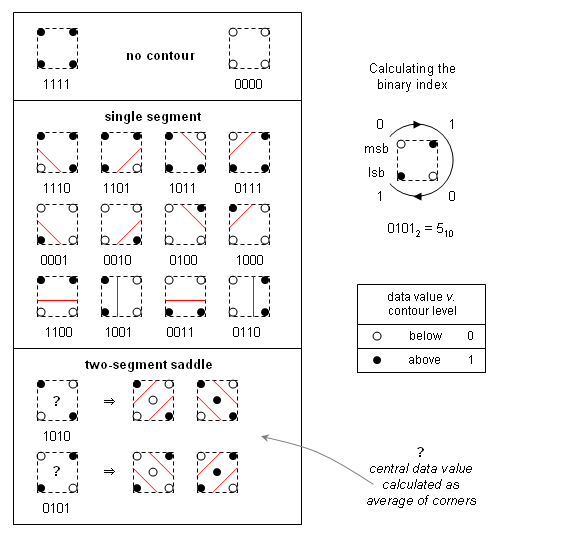

The parameters of the function are:
- `cell`: the cell you want to get contour case for
- `thres`: the threshold/isovalue 

Function returns:
- an integer between `0` and `15` inclusive indicating the contouring cell's index in the contouring lookup table (`0` any time an out-of-bounds access is encountered)

In [5]:
def get_contour_case(cell, thres):
    binary_index = [int(v.value >= thres) for v in cell.vertices]
    decimal_index = int(''.join(str(b) for b in binary_index), 2)
    return decimal_index

## Disambiguating Saddle Points

There are some cases, called saddle points, where the contour is ambiguous (there are multiple edges that can serve as a valid contour for that case). To resolve the ambiguous cases, I need to average the function values at the corners of the contouring cell to generate a sample in the square center.

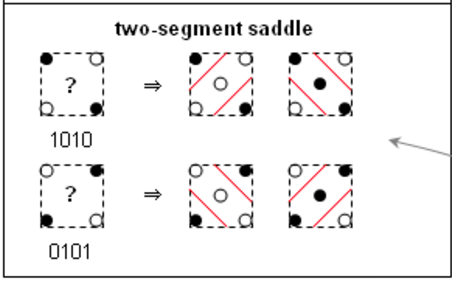

The parameters of the function are:
- `cell`: the cell you want to check it for
- `thres`: the threshold/isovalue 

Function returns:
- `True` if the averaged sample cell is greater than or equal to the threshold, and `False` otherwise.

In [6]:
def avg_above_theshold(cell, thres):
    return sum([v.value for v in cell.vertices]) / 4.0 >= thres

## Interpolation

To smoothen the contours, I will use linear interpolation to find the exact position of the contour line along the edges of the cell.

The parameters of the function are:
- `v1`: the first vertex to use for linear interpolation
- `v2`: the second value to use for linear interpolation
- `thres`: the number for which to find the relative position between `v1` and `v2`

Function returns:
- a float between 0 and 1 designating the relative position of `t` between `v1` and `v2`

In [7]:
def interpolate(v1, v2, thres):
    return (thres - v1.value) / (v2.value - v1.value)

### Get interpolated coordinates

Use interpolate function to linearly interpolate the positions of the two grid points (vertices).

The parameters of the function are:
- `v1`: the first vertex to use for linear interpolation
- `v2`: the second value to use for linear interpolation
- `thres`: the number for which to find the relative position between `v1` and `v2`

Function returns:
- a (x, y) interpolated coordinates 

In [8]:
def get_coordinates(v1, v2, thres):
    t = interpolate(v1, v2, thres)
    
    x = v1.column + t * (v2.column - v1.column)
    y = v1.row + t * (v2.row - v1.row)
    return x, y

## Get coordinates

Every contour case can be transformed to a list of edges where the segment should be created:

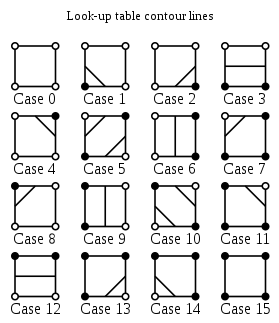
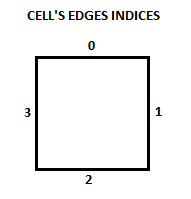

In [9]:
case_to_edges = {
    1: [[2, 3]], 2: [[1, 2]],  3: [[1, 3]],  4: [[0, 1]],  6: [[0, 2]],  7: [[0, 3]],
    8: [[0, 3]], 9: [[0, 2]], 11: [[0, 1]], 12: [[1, 3]], 13: [[1, 2]], 14: [[2, 3]],
    "10_5": [[0, 1], [2, 3]], 
    "5_10": [[1, 2], [0, 3]]
}

Lets now obtain the exact coordinates of a contour line's endpoints.

The parameters of the function are:
- `cell`: the cell you want to get contour case for
- `thres`: the threshold/isovalue 

Function returns:
- a list of pairs of (x, y) coordinates indicating contour segments within a cell e.g. [ [(x1,y1),(x2,y2)], [(x3,y3),(x4,y4)] ]. If any of the grid cells bordering a countouring cell are out of bounds, function returns an empty list `[]`.

In [10]:
def get_segment_coordinates(edge, cell, thres):
    segment_coordinates = []
    for edge_i in edge:
        v1, v2 = cell.get_edge(edge_i)
        if v1.value < thres < v2.value:
            x, y = get_coordinates(v1, v2, thres)
            segment_coordinates.append((y, x))
    return segment_coordinates


def get_cell_segments(cell, thres):
    if cell is None:
        return []

    contour_case = get_contour_case(cell, thres)
    
    if contour_case in [0, 15]: 
        return []
    
    if contour_case in [5, 10]:
        saddle_above_thres = avg_above_theshold(cell, thres)

        if ((contour_case == 10) & saddle_above_thres) | ((contour_case == 5) & (not saddle_above_thres)):
            edges = case_to_edges["10_5"]
        if ((contour_case == 5) & saddle_above_thres) | ((contour_case == 10) & (not saddle_above_thres)):
            edges = case_to_edges["5_10"]
    else:
        edges = case_to_edges[contour_case]
    
    return [get_segment_coordinates(edge, cell, thres) for edge in edges]

We can now apply the above function to all of the contouring cells in our grid and produce a list of pairs of coordinates, where each pair of coordinates represents a line segment used for drawing the contours of a Marching Squares invocation.

The parameters of the function are:
- `thres`: the threshold/isovalue 
- `grid`: a 2-D array of cells

Function returns:
- a list of pairs of (x, y) coordinates indicating all contour segments for the grid e.g. [ [(x1,y1),(x2,y2)], [(x3,y3),(x4,y4)] ].

In [11]:
def get_contour_segments(grid, thres):
    contour_segments = []
    for row in grid.cells:
        for cell in row:
            cell_segment = get_cell_segments(cell, thres)
            if cell_segment == []:
                continue
            contour_segments.append(cell_segment[0])
    return contour_segments

## Creating a colormap

Create a [Plasma color map](https://www.kennethmoreland.com/color-advice/) for mapping scalar data to colors.

Function returns:
- a dictionary containing a Plasma color map usable by matplotlib's LinearSegmentedColormap() function.

# Visualization
Generate our 2-D interactive visualization! You should be able to toggle the visualization to see the images from the beginning of this notebook.

Use a 2-D Gaussian function to generate the grid that we will apply marching squares to.

In [12]:
def color_map_plasma():
    return {'red': [(0.0,  13/255, 13/255),
                   (0.142857142857142,  84/255, 84/255),
                   (0.285714285714285,  139/255, 139/255),
                   (0.428571428571428,  185/255, 185/255),
                   (0.571428571428571,  219/255, 219/255),
                   (0.714285714285714,  244/255, 244/255),
                   (0.857142857142857,  254/255, 254/255),
                   (1.0,  240/255, 240/255)],
         'green': [(0.0,  8/255, 8/255),
                   (0.142857142857142,  2/255, 2/255),
                   (0.285714285714285,  10/255, 10/255),
                   (0.428571428571428,  50/255, 50/255),
                   (0.571428571428571,  92/255, 92/255),
                   (0.714285714285714,  136/255, 136/255),
                   (0.857142857142857,  188/255, 188/255),
                   (1.0,  249/255, 249/255)],
         'blue':  [(0.0,  135/255, 135/255),
                   (0.142857142857142,  163/255, 163/255),
                   (0.285714285714285,  165/255, 165/255),
                   (0.428571428571428,  137/255, 137/255),
                   (0.571428571428571,  104/255, 104/255),
                   (0.714285714285714,  73/255, 73/255),
                   (0.857142857142857,  43/255, 43/255),
                   (1.0,  33/255, 33/255)]}

In [13]:
def gauss_2d(mu, sigma, size=10):
    x, y = np.meshgrid(np.linspace(-1,1,size), np.linspace(-1,1,size))
    d    = np.sqrt(x*x+y*y)
    g    = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
    return g

In [14]:
class March(object):
    def __init__(self,res=32,thres=0.5,size=320):

        #Initialize variables
        self.res      = res                      #Number of grid cells per axis
        self.thres    = thres                    #Threshold for binarization
        self.size     = size                     #Size of image (in pixels)
        self.contours = 0                        #Whether we're showing contours (0 = off,  1 = normal, 2 = interpolated)
        self.cmap     = self.colorMapGrayscale() #Default grayscale color map
        self.cmapi    = 0                        #Index of color map (0 = gray, 1 = plasma, 2 = custom)

        #Hardcode some cells to start with to test all cases
        self.grid    = Grid(gauss_2d(0.5,0.4,self.res))

        #Compute other useful variables from grid size
        self.step     = self.size // self.res #Spacing between grid lines (in pixels)

        #Set up axes
        self.fig, self.axes = plt.subplots()
        self.axes.set_aspect('equal')
        plt.subplots_adjust(bottom=0.2)

        #Set up buttons
        self.btog = Button(plt.axes([0.61, 0.05, 0.2, 0.075]), 'No Contours')
        self.btog.on_clicked(self.toggle_contours)
        self.bmap = Button(plt.axes([0.41, 0.05, 0.2, 0.075]), 'Grayscale')
        self.bmap.on_clicked(self.toggle_colormap)

        #Perform initial drawing
        self.redraw()

    def show(self):
        plt.show()

    def update(self):
        self.fig.canvas.draw()

    def toggle_contours(self,event):
        #Toggle whether we draw contours or not
        self.contours = (self.contours + 1) % 3
        self.redraw()

    def toggle_colormap(self,event):
        self.cmapi = (self.cmapi+1)%2
        if self.cmapi == 0:
            self.cmap = self.colorMapGrayscale()
            self.bmap.label.set_text("Grayscale")
        elif self.cmapi == 1:
            self.cmap = color_map_plasma()
            self.bmap.label.set_text("Plasma")
        self.redraw()

    def redraw(self):
        # Regenerate a blank white canvas withou axis lines or tick marks
        self.axes.clear()
        self.axes.set_yticks([])
        self.axes.set_xticks([])
        self.axes.set_yticklabels([])
        self.axes.set_xticklabels([])

        #Invert y axis to match up with array ordering
        self.axes.invert_yaxis()

        #Draw the image from our img matrix
        self.drawImage()
        if self.contours == 0:
            for i in range(1,self.res): #Draw image grid
                self.axes.plot([0,self.size-1], [self.step*i,self.step*i], color='black', linestyle='-', linewidth=1)
                self.axes.plot([self.step*i,self.step*i], [0,self.size-1], color='black', linestyle='-', linewidth=1)
            self.btog.label.set_text('No Contours')
        else:  # Draw contours and contour grid
            for i in range(self.res): #Draw contour grid
                self.axes.plot([0,self.size-1], [self.step*(i+0.5),self.step*(i+0.5)], color='gray', linestyle='-', linewidth=1)
                self.axes.plot([self.step*(i+0.5),self.step*(i+0.5)], [0,self.size-1], color='gray', linestyle='-', linewidth=1)
            if self.contours == 1:
                self.btog.label.set_text('Rough Contours')
                self.drawTableLookupContours()
            else:
                self.btog.label.set_text('Interp. Contours')
                self.drawInterpolatedContours()

        #Update the underlying plot
        self.update()

    def colorMapGrayscale(self):
        cdict = {'red':   [[0, 0, 0],
                           [1, 1, 1]],
                 'green': [[0, 0, 0],
                           [1, 1, 1]],
                 'blue':  [[0, 0, 0],
                           [1, 1, 1]]}
        return cdict

    def drawImage(self):
        newcmp = LinearSegmentedColormap('testCmap', segmentdata=self.cmap, N=256)
        self.axes.imshow(gauss_2d(0.5,0.4,self.size),cmap=newcmp)

    def drawTableLookupContours(self):
        for y,row in enumerate(self.grid.cells):
            for x,cell in enumerate(row):
                case = get_contour_case(cell, self.thres)
                self.drawCellContourByCase(y,x,case)

    def drawInterpolatedContours(self):
        segments = get_contour_segments(self.grid, self.thres)
        print(segments)
        for s in segments:
            x1 = self.step*(0.5+s[0][0])
            x2 = self.step*(0.5+s[1][0])
            y1 = self.step*(0.5+s[0][1])
            y2 = self.step*(0.5+s[1][1])
            self.axes.plot([x1,x2], [y1,y2], color='green', linestyle='-', linewidth=1)

    def drawCellContourByCase(self,yrow,xcol,case):
        if case in [0,15]:
            return #Nothing to draw for empty cells, completely surrounded cells, or border cells

        #Handle saddle points
        if case in [5]:
            if avg_above_threshold(self.grid.get_cell(yrow,xcol),self.thres):
                self.drawCellContourByCase(yrow,xcol,2)
                self.drawCellContourByCase(yrow,xcol,7)
            else:
                self.drawCellContourByCase(yrow,xcol,11)
                self.drawCellContourByCase(yrow,xcol,14)
            return
        if case in [10]:
            if avg_above_threshold(self.grid.get_cell(yrow,xcol),self.thres):
                self.drawCellContourByCase(yrow,xcol,11)
                self.drawCellContourByCase(yrow,xcol,14)
            else:
                self.drawCellContourByCase(yrow,xcol,2)
                self.drawCellContourByCase(yrow,xcol,7)
            return

        #Compute coordinates based on case lookup table
        s    = self.step
        ymin = s*yrow + (0         if case in [4,6,7,8,9,11]   else s//2)
        ymax = s*yrow + (self.step if case in [1,2,6,9,13,14]  else s//2)
        xmin = s*xcol + (0         if case in [1,3,7,8,12,14]  else s//2)
        xmax = s*xcol + (self.step if case in [2,3,4,11,12,13] else s//2)
        if case in [2,7,8,13]: #Reverse direction for lines drawn up and right (i.e., x increases while y decreases)
            xmin,xmax = xmax,xmin

        #Contour lines should be drawn halfway between grid cells, so set an offset
        off = s//2
        #Smooth contours should have different color
        color = 'red' if self.contours == 1 else 'green'
        #Actually draw the contour lines
        self.axes.plot([xmin+off, xmax+off], [ymin+off, ymax+off], color=color, linestyle='-', linewidth=1)
        return

In [15]:
March(res = 60, size = 600)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …